# The Beatles' Covers Recognition

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from scipy import ndimage
from rapidfuzz import process, fuzz
import json

COVERS_FOLDER_INPUT = "beatles_covers"
COVERS_FOLDER_OUTPUT = "beatles_covers_stft"
BEATLES_FOLDER_INPUT = "beatles_songs"
BEATLES_FOLDER_OUTPUT = "beatles_songs_stft"

## Generating the spectograms

In [2]:
def process_audio(file_name, input_folder, output_folder, duration=30, sr=22050):
    y, _ = librosa.load(f"{input_folder}/{file_name}", sr=sr, duration=duration)

    # Trim initial silence
    y_trimmed, _ = librosa.effects.trim(y, top_db=30)
    y_trimmed = y_trimmed[:int(duration * sr)]

    D = librosa.stft(y_trimmed)
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    np.save(f"{output_folder}/{file_name}", D_db)

In [3]:
def generate_spectograms(folder_input, folder_output):
    for file in os.listdir(folder_input):
        output_file = f"{folder_output}/{file}.npy"

        if os.path.exists(output_file):
            print(f"Skipping {file}: Output file already exists.")
            continue

        try:
            process_audio(file, folder_input, folder_output)
        except Exception as e:
            print(f"Error processing {file}: {e}")

generate_spectograms(COVERS_FOLDER_INPUT, COVERS_FOLDER_OUTPUT)
generate_spectograms(BEATLES_FOLDER_INPUT, BEATLES_FOLDER_OUTPUT)

Skipping Elvis Costello performs ＂Penny Lane＂ at the Gershwin Prize for Paul McCartney [HVcfPzoXWnY].mp4: Output file already exists.
Skipping Joe Jackson covers John Lennon's Girl (live 2010) HD [cVJ8tKvpmE4].mp4: Output file already exists.
Skipping Rosanne Cash I Don't Want To Spoil The Party [_fjsQPS5l-w].mp4: Output file already exists.
Skipping Fool on the Hill - Maggie Bell [SVVF4QOQfK4].mp4: Output file already exists.
Skipping P.J. Proby · That Means A Lot (1965) [V6-26dnHARI].mp4: Output file already exists.
Skipping Hardin & York - Northern Medley [XSKJap9wydA].mp4: Output file already exists.
Skipping Let it be - Ray Charles [eof2c5fTcI8].mp4: Output file already exists.
Skipping Tenacious D - MSG And Your Bird Can Sing (Beatles) [ePo7wvjYBe8].mp4: Output file already exists.
Skipping CHER ＂THE LONG AND WINDING ROAD＂ (1973) STUDIO RECORDING [nziq7ZkqSeE].mp4: Output file already exists.
Skipping Norwegian Wood- Jan & Dean [N03RUqh5pnY].mp4: Output file already exists.
Skipp

/tmp/ipykernel_223019/1201157192.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(f"{input_folder}/{file_name}", sr=sr, duration=duration)
/home/cesar/.local/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


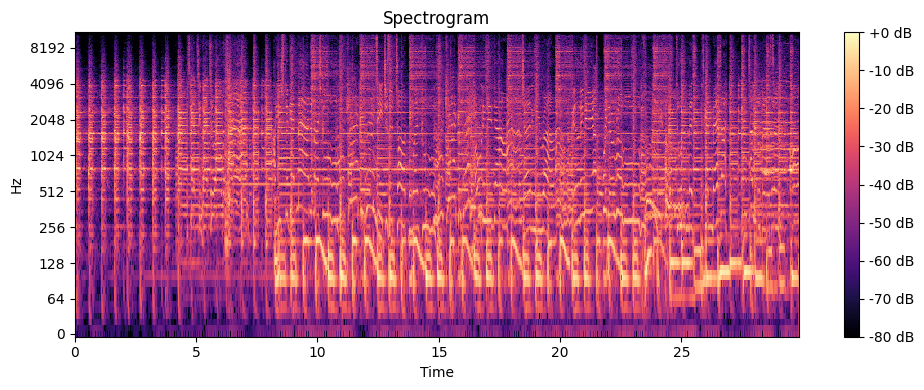

In [94]:
def plot_spectrogram(stft, constellation=None):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(stft, sr=22050, x_axis='time', y_axis='log', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()

    if constellation is not None and constellation.any():
        freqs = librosa.fft_frequencies(sr=22050, n_fft=2*(stft.shape[0]-1))
        times = librosa.frames_to_time(np.arange(stft.shape[1]), sr=22050, hop_length=512)
        x, y = np.where(constellation.T)
        plt.scatter(times[x], freqs[y], s=100, alpha=0.6, edgecolor='k')

    plt.show()

example_stft = np.load(f"{BEATLES_FOLDER_OUTPUT}/04 The Beatles - Getting Better.flac.npy")
plot_spectrogram(example_stft)

## Labeling the data

I've generated the `labels.json` file, but some stuff were missing and some misplaced, so I had to manually alter some songs. Final labels on `labels_final.json`

In [5]:
def clean_beatles_song_name(filename):
    filename = re.sub(r"\.(flac|mp4)\.npy$", "", filename)
    filename = re.sub(r"\[.*?\]", "", filename).strip()
    filename = filename.replace("(Remastered 2009)", "").strip()
    filename = re.sub(r"^\d+\s*", "", filename)
    filename = re.sub(r"(?i)^the beatles\s*-\s*", "", filename)

    return filename

def clean_cover_name(filename):
    filename = re.sub(r"\.mp4\.npy$", "", filename)
    filename = re.sub(r"\[.*?\]", "", filename).strip()
    filename = re.sub(r"\bcover\b", "", filename, flags=re.IGNORECASE).strip()
    filename = re.sub(r"\bbeatles\b", "", filename, flags=re.IGNORECASE).strip()
    
    return filename

def match_covers_to_songs(beatles_songs, covers):
    song_dict = {file_name: [] for _, file_name in beatles_songs}
    beatles_cleaned_songs = [clean_name for clean_name, _ in beatles_songs]
    song_name_to_file = {clean_name: file_name for clean_name, file_name in beatles_songs}

    for cover_name, original_name in covers:
        best_match, score, _ = process.extractOne(cover_name, beatles_cleaned_songs, scorer=fuzz.ratio)

        if score > 40:
            original_song_file = song_name_to_file[best_match]
            song_dict[original_song_file].append(original_name)
        else:
            print(f"Not labeled: {original_name}")

    return {k: v for k, v in song_dict.items()}

cleaned_beatles_songs = [(clean_beatles_song_name(f), f) for f in os.listdir(BEATLES_FOLDER_OUTPUT)]
cleaned_covers = [(clean_cover_name(f), f) for f in os.listdir(COVERS_FOLDER_OUTPUT)] 

matches = match_covers_to_songs(cleaned_beatles_songs, cleaned_covers)
with open("labels.json", "w", encoding="utf-8") as f:
    json.dump(matches, f, indent=4, ensure_ascii=False)

Not labeled: Robin Williams & Bobby McFerrin - Come Together (George Martin： In My Life CD) [j6VbspP47oY].mp4.npy
Not labeled: Ringo Starr playing with The Beach Boys July 4th 1984 1 [kINQXKLm334].mp4.npy
Not labeled: Sacred Rite ＂Eleanor Rigby (Beatles Cover)＂ Album： Is Nothing Sacred [mVKOcWia8_k].mp4.npy
Not labeled: Stefanie Hempel ALL THINGS MUST PASS [hhQ3hSPZLDk].mp4.npy
Not labeled: St Vincent - Dig A Pony - Live @ All Points West Festival 8⧸1⧸09 in HD [lan-UQfN0zs].mp4.npy
Not labeled: Frank Zappa Beatles medley - Cleveland 5th March 1988 [_kna4NiU-eM].mp4.npy
Not labeled: LOS FABULOSOS CADILLACS - TWIST Y GRITOS - VIVO -  1989 [nuuyOAy-TBo].mp4.npy
Not labeled: Amy Winehouse - All my lovin' (The Beatles's cover) [9FiQnrRT16s].mp4.npy
Not labeled: Joe Jackson covers John Lennon's Girl (live 2010) HD [cVJ8tKvpmE4].mp4.npy
Not labeled: CHER ＂THE LONG AND WINDING ROAD＂ (1973) STUDIO RECORDING [nziq7ZkqSeE].mp4.npy
Not labeled: Jimmy Page & Yes - I'm Down (Beatles cover) [j90CnFv3

## Cover Detection: Embedding Generation with CNNs

In [6]:
with open("labels.json", "r", encoding="utf-8") as f:
    labels = json.load(f)

total_covers_with_labels = 0
for song, covers in labels.items():
    total_covers_with_labels += len(covers)
print(f"Total number of covers: {total_covers_with_labels}")

Total number of covers: 182


In [92]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler

def build_autoencoder(input_dim, encoding_dim=10):
    """ Build and return an autoencoder model for dimensionality reduction. """
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)  # Extract encoder separately
    
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

beatles_songs = {name: np.load(f"{BEATLES_FOLDER_OUTPUT}/{name}") for name in os.listdir('beatles_songs_stft/')}
beatles_songs_mfcc = {name: librosa.feature.mfcc(S=stft) for name, stft in beatles_songs.items()}

mfcc_list = [mfcc.T for mfcc in beatles_songs_mfcc.values()]  # Transpose to (time_steps, n_mfcc)
mfcc_data = np.vstack(mfcc_list)  # Stack all MFCCs together

scaler = StandardScaler()
mfcc_data = scaler.fit_transform(mfcc_data)

input_dim = mfcc_data.shape[1]

autoencoder, encoder = build_autoencoder(input_dim, encoding_dim=64)
autoencoder.fit(mfcc_data, mfcc_data, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
8775/8775 - 5s - 582us/step - loss: 0.0215
Epoch 2/10
8775/8775 - 5s - 563us/step - loss: 5.6312e-05
Epoch 3/10
8775/8775 - 5s - 562us/step - loss: 4.4839e-05
Epoch 4/10
8775/8775 - 5s - 573us/step - loss: 4.0952e-05
Epoch 5/10
8775/8775 - 5s - 577us/step - loss: 4.1667e-05
Epoch 6/10
8775/8775 - 5s - 550us/step - loss: 3.9545e-05
Epoch 7/10
8775/8775 - 5s - 550us/step - loss: 3.9440e-05
Epoch 8/10
8775/8775 - 5s - 556us/step - loss: 3.7669e-05
Epoch 9/10
8775/8775 - 5s - 551us/step - loss: 3.9080e-05
Epoch 10/10
8775/8775 - 5s - 552us/step - loss: 3.6118e-05


In [90]:
beatles_embeddings = {name: np.mean(encoder.predict(mfcc.T, verbose=0), axis=0) for name, mfcc in beatles_songs_mfcc.items()}

cover_songs = {name: np.load(f"{COVERS_FOLDER_OUTPUT}/{name}") for name in os.listdir('beatles_covers_stft/')}
cover_songs_mfcc = {name: librosa.feature.mfcc(S=stft) for name, stft in cover_songs.items()}
cover_embeddings = {name: np.mean(encoder.predict(mfcc.T, verbose=0), axis=0) for name, mfcc in cover_songs_mfcc.items()}

In [91]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cityblock

scaler = MinMaxScaler()
embedding_matrix = np.array(list(beatles_embeddings.values()) + list(cover_embeddings.values()))
scaled_embeddings = scaler.fit_transform(embedding_matrix)

# Update dictionaries with normalized values
beatles_embeddings = {name: scaled_embeddings[i] for i, name in enumerate(beatles_embeddings.keys())}
cover_embeddings = {name: scaled_embeddings[i + len(beatles_embeddings)] for i, name in enumerate(cover_embeddings.keys())}

def cosine_distance(embedding1, embedding2):
    if np.all(embedding1 == 0) or np.all(embedding2 == 0):
        return 1.0

    similarity = cosine_similarity(embedding1.reshape(1, -1), embedding2.reshape(1, -1))
    distance = 1 - similarity[0][0]
    return distance

covers_found = 0
for name, embedding in cover_embeddings.items():

    smallest_difference = ("null", float("inf"))
    for beatles_song, beatles_embedding in beatles_embeddings.items():
        dist = cosine_distance(embedding, beatles_embedding)
        if dist < smallest_difference[1]:
            smallest_difference = (beatles_song, dist)

    # If it's a cover
    if name in labels[smallest_difference[0]]:
        print(f"\t{name} is a cover of {smallest_difference[0]} with score {smallest_difference[1]}")
        covers_found += 1
        
print(f"Accuracy is {covers_found/total_covers_with_labels}")

	Bee Gees and Peter Frampton -I Want You [JHyDulGDnvw].mp4.npy is a cover of 14 The Beatles (With Billy Preston) - Don_t Let Me Down.flac.npy with score 0.0004705190658569336
Accuracy is 0.005494505494505495


## Constellation map

kappa: Controls frequency sensitivity. Increasing it will group fewer but stronger peaks. <br>
tau: Defines the region in time to consider as a local maximum. Increasing it reduces the number of peaks. <br>
threshold: Since your STFT values are in dB, this threshold is detecting even quieter points.

In [173]:
def plot_chromagram(chroma, title, constellation=None, sr=22050, hop_length=512):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sr, hop_length=hop_length, cmap='coolwarm')
    plt.colorbar(label="Intensity")
    plt.title(title)

    if constellation is not None and np.any(constellation):
        # Extract peak positions from the constellation matrix
        peak_rows, peak_cols = np.where(constellation)  # No transpose needed

        # Convert frame indices to time for correct alignment
        times = librosa.frames_to_time(peak_cols, sr=sr, hop_length=hop_length)

        # Overlay constellation peaks
        plt.scatter(times, peak_rows, c='r', s=40, marker='*', edgecolor='black', alpha=0.7)

    plt.tight_layout()
    plt.show()

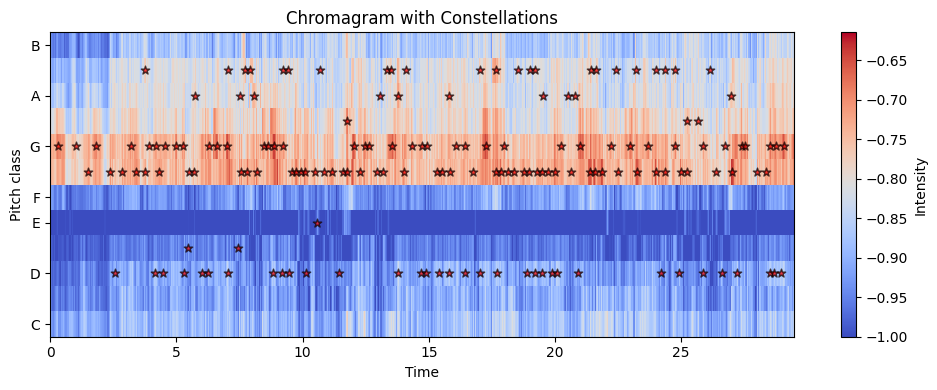

In [ ]:
def constellation_map(stft, kappa=1, tau=5, thresh=-0.85):
    """Creates a chromagram constellation map with local maximum suppression."""

    # 1. Calculate Chromagram:
    chroma = librosa.feature.chroma_stft(S=stft, sr=22050)

    result = ndimage.maximum_filter(chroma, size=[2*kappa+1, 2*tau+1], mode='constant')
    peaks = np.zeros_like(chroma, dtype=bool)
    for i in range(chroma.shape[0]):
        for j in range(chroma.shape[1]):
            if chroma[i, j] == result[i, j] and result[i, j] > thresh:
                neighborhood = chroma[max(0, i-1):min(chroma.shape[0], i+2), 
                                      max(0, j-1):min(chroma.shape[1], j+2)]
                if chroma[i,j] == np.max(neighborhood):
                    peaks[i,j] = True

    return peaks

beatles_stft = np.load(f"{BEATLES_FOLDER_OUTPUT}/14 The Beatles - Tomorrow Never Knows.flac.npy")
chromagram = librosa.feature.chroma_stft(S=beatles_stft, sr=22050)

constellation = constellation_map(beatles_stft)
plot_chromagram(chromagram, "The Beatles - Tomorrow Never Knows", constellation)

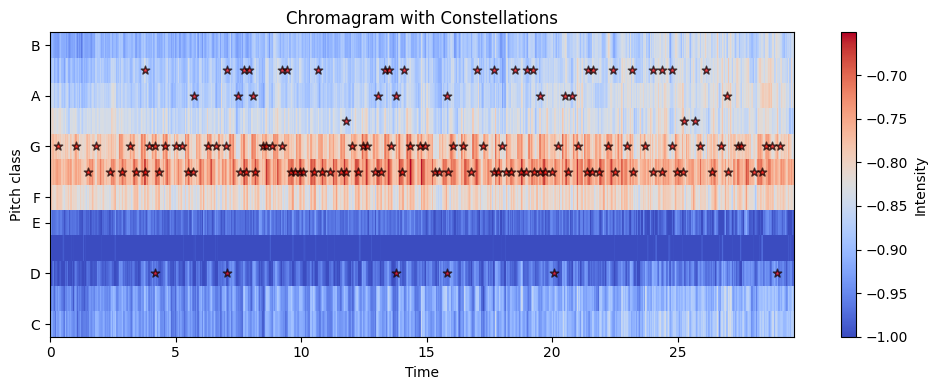

In [ ]:
query_stft = np.load(f"{COVERS_FOLDER_OUTPUT}/801 - Tomorrow Never Knows [UkGXUn0Kuuw].mp4.npy")
chromagram_query = librosa.feature.chroma_stft(S=query_stft, sr=22050)

constellation_query = constellation_map(query_stft)
plot_chromagram(chromagram_query, "801 - Tomorrow Never Knows",constellation)

In [200]:
from collections import defaultdict

def create_hash(constellation, time_delta=10):
    peaks = np.column_stack(np.where(constellation))
    hashes = defaultdict(list)

    for i, (t1, p1) in enumerate(peaks):
        for j in range(i + 1, min(i + time_delta, len(peaks))):
            t2, p2 = peaks[j]
            hash_val = hash((p1, p2, t2 - t1))
            hashes[hash_val].append(t1)

    return hashes

def build_beatles_index(beatles_stfts, kappa=1, tau=5, thresh=-0.85):
    hash_index = defaultdict(list)

    for song_name, stft in beatles_stfts.items():
        constellation = constellation_map(stft, kappa, tau, thresh)
        song_hashes = create_hash(constellation)

        for hash_val, times in song_hashes.items():
            for t in times:
                hash_index[hash_val].append((song_name, t))

    return hash_index


beatles_songs = {name: np.load(f"{BEATLES_FOLDER_OUTPUT}/{name}") for name in os.listdir('beatles_songs_stft/')}
beatles_index = build_beatles_index(beatles_songs)

In [209]:
def query_song(query_stft, beatles_index, time_delta=10, kappa=1, tau=5, thresh=-0.85):
    query_constellation = constellation_map(query_stft, kappa, tau, thresh)
    query_hashes = create_hash(query_constellation, time_delta=time_delta)

    # 1. Count Matches:
    match_counts = defaultdict(list)
    for query_hash, query_times in query_hashes.items():
        if query_hash in beatles_index:
            for beatles_song, beatles_time in beatles_index[query_hash]:
                for query_time in query_times:
                    offset = beatles_time - query_time
                    match_counts[beatles_song].append(offset)

    # 2. Find Best Match (using median offset for robustness):
    best_match = None
    max_matches = 0
    best_median_offset = None

    for song_name, offsets in match_counts.items():
        num_matches = len(offsets)
        if num_matches > max_matches:
            max_matches = num_matches
            best_match = song_name
            best_median_offset = np.median(offsets)  # Use median for robustness
        elif num_matches == max_matches: #Tie breaker logic, if same number of matches, check for minimal offset
          current_median_offset = np.median(offsets)
          if abs(current_median_offset) < abs(best_median_offset):
            best_match = song_name
            best_median_offset = current_median_offset

    return best_match, best_median_offset, max_matches  # Return best match and offset

def find_covers(beatles_index, time_delta=10, kappa=1, tau=5, thresh=-0.85):
    with open("labels_final.json", "r", encoding="utf-8") as f:
        labels = json.load(f)

    total_covers_with_labels = 0
    for song, covers in labels.items():
        total_covers_with_labels += len(covers)

    total_matches = 0
    total = 0
    for song in os.listdir(f"{COVERS_FOLDER_OUTPUT}"):
        query_stft = np.load(f"{COVERS_FOLDER_OUTPUT}/{song}")
        best_match, best_offset, num_matches = query_song(query_stft, beatles_index, time_delta, kappa, tau, thresh)
        if best_match:
            if song in labels[best_match]:
                print(f"Found cover: {song} is cover of {best_match} (Offset: {best_offset}, Matches: {num_matches})")
                total_matches += 1
        total +=1

    return total_matches/total

In [221]:
hyperparameters = {
    "time_delta": [10, 20, 30, 40, 50],
    "tau": [3, 5, 7],
    "thresh": [-0.7, -0.8, -0.9, -1.0, -1.1, -1.2, -1.3, -1.4, -1.5],
}

for time_delta in hyperparameters["time_delta"]:
    for tau in hyperparameters["tau"]:
        for thresh in hyperparameters["thresh"]:
            print(f"time_delta={time_delta}, tau={tau}, thresh={thresh}")
            print(f"Accuracy: {find_covers(beatles_index, time_delta=time_delta, tau=tau, thresh=thresh)}")


time_delta=10, tau=3, thresh=-0.7
Found cover: The Fray - Fixing A Hole (Beatles Cover) [RL4RFBsfjTk].mp4.npy is cover of 05 The Beatles - Fixing A Hole.flac.npy (Offset: 0.0, Matches: 4)
Found cover: Tenacious D - MSG And Your Bird Can Sing (Beatles) [ePo7wvjYBe8].mp4.npy is cover of 09 The Beatles - And Your Bird Can Sing.flac.npy (Offset: 2.0, Matches: 3)
Accuracy: 0.009216589861751152
time_delta=10, tau=3, thresh=-0.8
Found cover: Billy Joel - I'll Cry Instead (The Beatles Cover) [9LeePEK5NQI].mp4.npy is cover of 09 The Beatles - I_ll Cry Instead.flac.npy (Offset: 0.0, Matches: 19)
Found cover: I'm Down - Aerosmith (Lyrics) [npG_SQaohro].mp4.npy is cover of 18 The Beatles - I_m Down.flac.npy (Offset: -1.0, Matches: 13)
Accuracy: 0.009216589861751152
time_delta=10, tau=3, thresh=-0.9
Found cover: Billy Joel - I'll Cry Instead (The Beatles Cover) [9LeePEK5NQI].mp4.npy is cover of 09 The Beatles - I_ll Cry Instead.flac.npy (Offset: 0.0, Matches: 19)
Found cover: The Tubes -- I Saw Her

In [ ]:
hyperparameters = {
    "time_delta": [10, 20],
    "tau": [1, 3, 5, 7, 9],
    "kappa": [1, 2, 3, 5, 9],
    "thresh": [-0.7, -0.75, -0.8, -0.85, -0.9],
}

for time_delta in hyperparameters["time_delta"]:
    for tau in hyperparameters["tau"]:
        for kappa in hyperparameters["kappa"]:
            for thresh in hyperparameters["thresh"]:
                print(f"time_delta={time_delta}, kappa={kappa}, tau={tau}, thresh={thresh}")
                print(f"Accuracy: {find_covers(beatles_index, time_delta=time_delta, kappa=kappa, tau=tau, thresh=thresh)}")

time_delta=10, kappa=1, tau=1, thresh=-0.7
Found cover: Billy Joel - I'll Cry Instead (The Beatles Cover) [9LeePEK5NQI].mp4.npy is cover of 09 The Beatles - I_ll Cry Instead.flac.npy (Offset: 0.0, Matches: 27)
Found cover: ＂I Call Your Name＂ The Mamas & the Papas [X_WlLYBfL-k].mp4.npy is cover of 11 The Beatles - I Call Your Name.flac.npy (Offset: 0.0, Matches: 14)
Accuracy: 0.009216589861751152
time_delta=10, kappa=1, tau=1, thresh=-0.75
Found cover: Billy Joel - I'll Cry Instead (The Beatles Cover) [9LeePEK5NQI].mp4.npy is cover of 09 The Beatles - I_ll Cry Instead.flac.npy (Offset: 0.0, Matches: 32)
Found cover: Amy Winehouse - All my lovin' (The Beatles's cover) [9FiQnrRT16s].mp4.npy is cover of 03 The Beatles - All My Loving.flac.npy (Offset: 2.0, Matches: 20)
Accuracy: 0.009216589861751152
time_delta=10, kappa=1, tau=1, thresh=-0.8
Found cover: Strawberry Fields Forever (Across The Universe) [xLiID6qFIsI].mp4.npy is cover of 08 The Beatles - Strawberry Fields Forever.flac.npy (Of